# SUMO DEMAND GENERATION

## Overview

Author: Joseph Severino
Contact: joseph.severino@nrel.gov

This notebook is a configuration notebook for building demand in XML format. SUMO uses XML files as input
files for simulation purposes. The beginning part of this notebook is clean and process the data for 
exploration so that a user understands the data they working with. The analysis is basic VDA to help guide 
which days to investigate. 

## Inputs

This notebook only takes the operational model input (i.e. "athena_sumo_v1.csv"). This data was generated based on flight arrivals and departures along with the predictive analysis the operational modelling team worked on.

## Outputs

There are two XML files that this notebook generates: a Trips file and an additional file. The trips file conatins all the entry, stopping and exit routes for all the patron vehicles at DFW.

In [ ]:
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element
from lxml import etree
from copy import copy
import os
import inspect
from xml.dom import minidom
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import DFW_gen_flow as gf

In [2]:
this_folder = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
this_folder

'/Users/jseverin/Athena/NREL_github/ATHENA-siem-sumo/Generate_SUMO_demand'

# Generating Demand from flight data model


In [3]:
demand = pd.read_csv('../Example_Files/athena_sumo_v1.csv')

In [4]:
demand.head()

,scheduled_fight_time,parking,pass,A,B,C,D,E,time,month,day,year
0,2017-10-01 00:00:00,15.0,33.0,43,24,48,28,3,00:00:00,10,1,2017
1,2017-10-01 00:30:00,23.0,21.0,25,14,27,13,2,00:30:00,10,1,2017
2,2017-10-01 01:00:00,15.0,15.0,13,7,14,7,1,01:00:00,10,1,2017
3,2017-10-01 01:30:00,11.0,10.0,12,7,14,6,1,01:30:00,10,1,2017
4,2017-10-01 02:00:00,11.0,12.0,14,8,14,9,1,02:00:00,10,1,2017


In [5]:
gf.addDayOfWeek(demand)

In [6]:
demand['total_pass'] = demand[['parking','pass','A','B','C','D','E']].sum(axis=1) # aggregating across the terminals

In [7]:
demand.head()

,scheduled_fight_time,parking,pass,A,B,C,D,E,time,month,day,year,day_of_week,total_pass
0,2017-10-01 00:00:00,15.0,33.0,43,24,48,28,3,00:00:00,10,1,2017,6,194.0
1,2017-10-01 00:30:00,23.0,21.0,25,14,27,13,2,00:30:00,10,1,2017,6,125.0
2,2017-10-01 01:00:00,15.0,15.0,13,7,14,7,1,01:00:00,10,1,2017,6,72.0
3,2017-10-01 01:30:00,11.0,10.0,12,7,14,6,1,01:30:00,10,1,2017,6,61.0
4,2017-10-01 02:00:00,11.0,12.0,14,8,14,9,1,02:00:00,10,1,2017,6,69.0


In [8]:
gf.extractDate(demand)

In [9]:
sorted_top10, sorted_bot10, median_days, sort_all = gf.buildTopBottomMedianDays(demand)

# Top 10 highest Volume days - Aggregated over the day


In [10]:
sorted_top10[['parking','pass','A','B','C','D','E','total_pass']]

,parking,pass,A,B,C,D,E,total_pass
date,,,,,,,,
2018-07-16,14800.0,4597.0,15364,8582,17241,8433,1006,70023.0
2018-06-07,13179.0,6108.0,15694,8652,17223,8198,1059,70113.0
2018-05-21,14632.0,5737.0,15262,8544,17273,8050,1015,70513.0
2018-06-25,15134.0,4901.0,15470,8775,17528,8382,1026,71216.0
2018-07-09,15050.0,4619.0,15654,8644,17640,8648,1032,71287.0
2018-06-18,15485.0,4553.0,15688,8716,17600,8656,1055,71753.0
2018-07-13,11614.0,5080.0,16880,9317,19035,8994,1136,72056.0
2018-06-08,11948.0,5648.0,16888,9476,18658,9202,1147,72967.0
2018-06-11,15339.0,5010.0,16152,9018,18089,8610,1088,73306.0


# Bottom 10 Volume Days

In [11]:
sorted_bot10[['parking','pass','A','B','C','D','E','total_pass']]

,parking,pass,A,B,C,D,E,total_pass
date,,,,,,,,
2018-03-31,5041.0,2981.0,7472,4161,8425,4002,513,32595.0
2018-02-03,5829.0,2927.0,8129,4515,9005,4368,554,35327.0
2018-01-20,5723.0,2864.0,8528,4719,9275,4543,582,36234.0
2018-04-07,5969.0,3001.0,8621,4920,9751,4662,574,37498.0
2018-01-27,5515.0,4752.0,8339,4704,9342,4365,552,37569.0
2017-11-24,4715.0,3200.0,9049,5047,10410,4923,617,37961.0
2017-12-02,6219.0,3532.0,8606,4815,9728,4520,579,37999.0
2017-12-31,5215.0,1675.0,9562,5394,10707,5088,648,38289.0
2017-11-23,6305.0,3086.0,8935,5017,9908,4945,589,38785.0


# Middle 10 days

In [12]:
median_days[['parking','pass','A','B','C','D','E','total_pass']]

,parking,pass,A,B,C,D,E,total_pass
date,,,,,,,,
2018-09-06,12561.0,6160.0,12012,6742,13450,6187,823,57935.0
2018-01-08,12879.0,4360.0,12400,7041,13898,6569,832,57979.0
2018-03-23,9758.0,5825.0,13047,7290,14559,6632,896,58007.0
2018-01-22,13406.0,4964.0,12128,6803,13440,6446,837,58024.0
2018-04-05,10754.0,5423.0,12833,7177,14190,6824,847,58048.0
2018-01-02,8598.0,3619.0,13972,7824,15643,7480,928,58064.0
2017-12-08,10249.0,5780.0,12745,7109,14390,6938,863,58074.0
2017-12-18,11592.0,4646.0,12881,7137,14351,6665,866,58138.0
2018-09-30,7708.0,2876.0,14623,8005,16271,7731,976,58190.0


## Distributions of Number of Vehicles/Day 

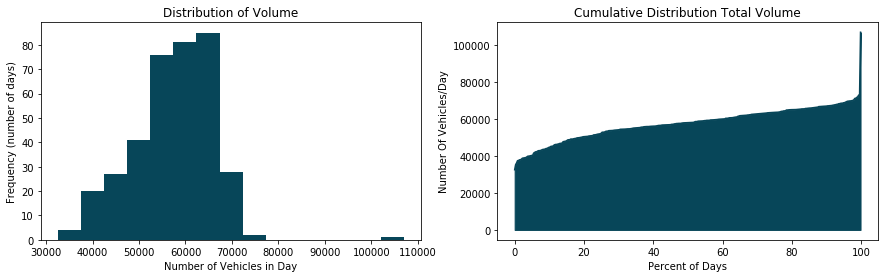

In [13]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.hist(sort_all['total_pass'],bins=15,color='#074659')
plt.title("Distribution of Volume")
plt.xlabel("Number of Vehicles in Day")
plt.ylabel("Frequency (number of days)")

plt.subplot(1, 2, 2)
sort_all.reset_index(inplace=True, drop=True)
sort_all['percentile'] = np.round(100*sort_all.index.values/sort_all.shape[0],3)
plt.plot(sort_all['percentile'],sort_all['total_pass'],color='#074659')
plt.fill_between(sort_all['percentile'],sort_all['total_pass'],color='#074659')
plt.title("Cumulative Distribution Total Volume")
plt.xlabel("Percent of Days")
plt.ylabel("Number Of Vehicles/Day")
plt.show()

In [48]:
day_df = demand.groupby("date").sum()


# Showing all data

Below you can see how volume varies through time over the past year. Notice one day that is exceptionally large compared to all the other days ("Mother's Day)

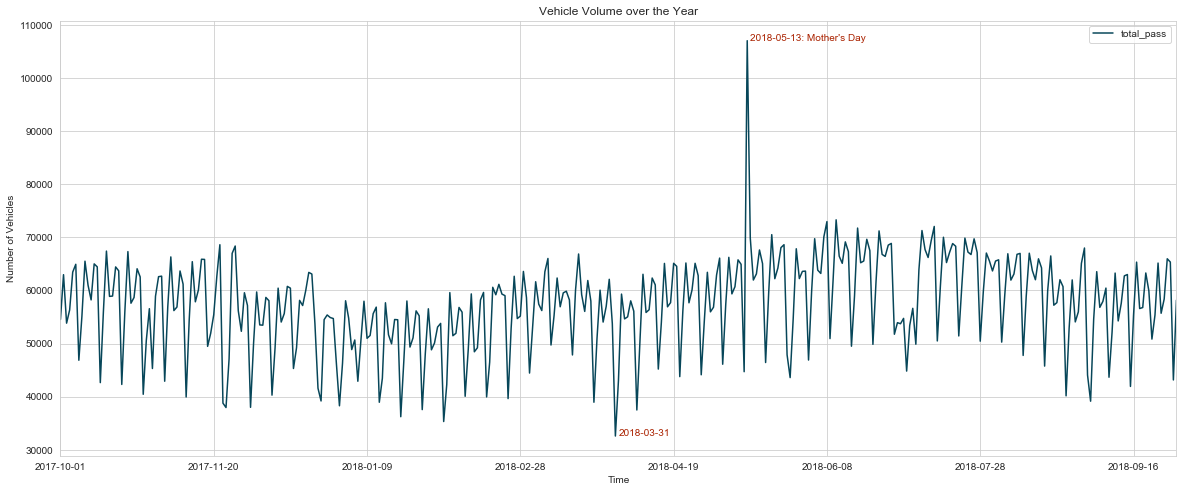

In [49]:
plt.figure(figsize=(20,8))
sns.set_style("whitegrid")
ax = day_df['total_pass'].plot(color="#074659")
max_value = np.max(day_df['total_pass'])
string_max = day_df['total_pass'].idxmax() + ": Mother's Day"
index_max = np.argmax(list(day_df['total_pass'])) +1
plt.text(index_max, max_value, string_max, color="#aa2200")
min_value = np.min(day_df['total_pass'])
string_min = day_df['total_pass'].idxmin() 
index_min = np.argmin(list(day_df['total_pass'])) +1
plt.text(index_min, min_value, string_min, color="#aa2200")
plt.legend()
plt.title("Vehicle Volume over the Year")
plt.xlabel("Time")
plt.ylabel("Number of Vehicles")
plt.show()

# Looking for highest and lowest volume by Day of the week

* Monday, Thursday and Friday are highest days
* Saturday and Sunday are the lowest days followed by Tuesday Wednesday

Text(0, 0.5, 'Number of Vehicles')

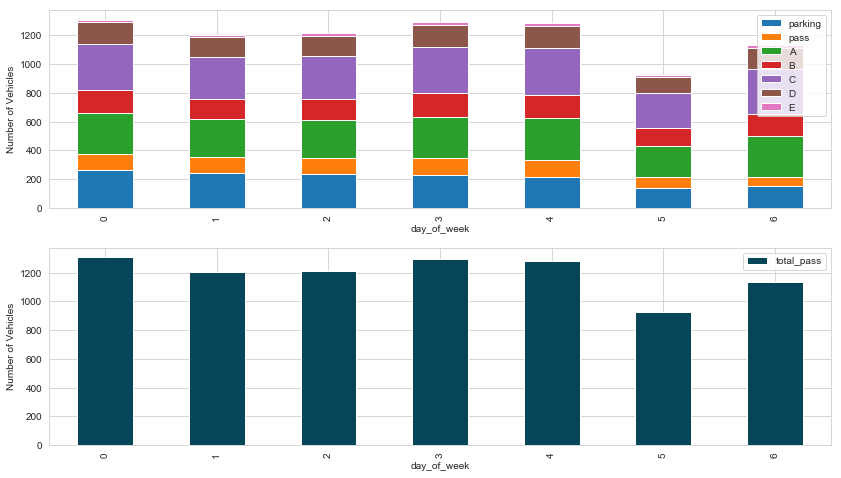

In [16]:
col = 'day_of_week'
fig, [ax,ax2] = plt.subplots(nrows=2,ncols=1,figsize=(14,8),sharey=True)
demand[['parking','pass','A','B','C','D','E','day_of_week']].groupby(col).mean().plot(kind="bar",ax=ax,stacked=True)
demand[['total_pass','day_of_week']].groupby(col).mean().plot(kind="bar",ax=ax2, color="#074659")
ax.set_ylabel("Number of Vehicles")
ax2.set_ylabel("Number of Vehicles")

* May, June July are highest months
* January, Febuary, December are lowest months

Text(0, 0.5, 'Number of Vehicles')

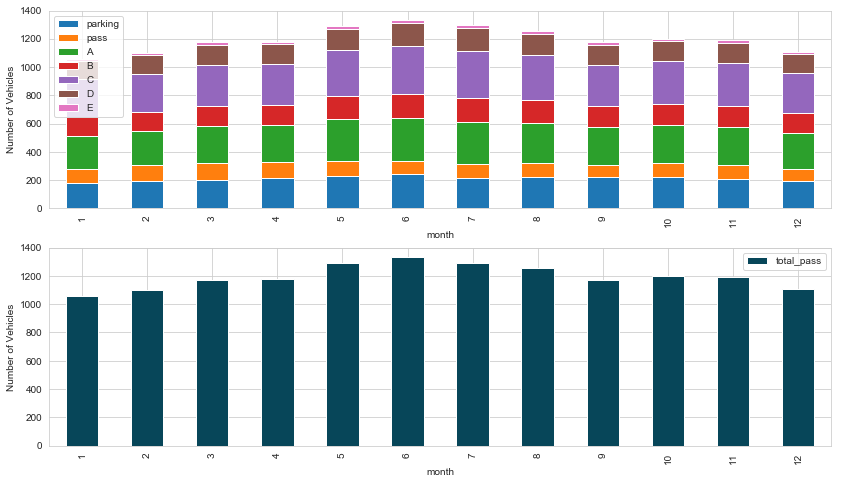

In [17]:
col = 'month'
fig, [ax,ax2] = plt.subplots(nrows=2,ncols=1,figsize=(14,8),sharey=True)
demand[['parking','pass','A','B','C','D','E','month']].groupby(col).mean().plot(kind="bar",ax=ax,stacked=True)
demand[['total_pass','month']].groupby(col).mean().plot(kind="bar",ax=ax2, color="#074659")
ax.set_ylabel("Number of Vehicles")
ax2.set_ylabel("Number of Vehicles")

# Sampling Day by Day Of Week and Month Based on Quantile/Mean

In [18]:
# Below is 
d = "Monday"
m = "June"
df = gf.top_day_month(demand,d,m,.95)
df.head(5)

0.95,parking,pass,A,B,C,D,E,month,day,year,day_of_week,total_pass
time,,,,,,,,,,,,
00:00:00,17.55,26.55,171.55,95.85,195.80,82.10,9.85,6.0,24.95,2018.0,1.0,583.75
00:30:00,8.85,19.85,94.25,47.85,95.85,53.10,6.00,6.0,24.95,2018.0,1.0,322.85
01:00:00,12.25,22.65,72.55,41.65,80.70,38.55,5.00,6.0,24.95,2018.0,1.0,262.45
01:30:00,12.85,16.55,56.20,31.95,61.75,27.40,3.85,6.0,24.95,2018.0,1.0,197.50
02:00:00,22.80,18.55,48.00,25.50,52.60,20.10,2.85,6.0,24.95,2018.0,1.0,187.25


In [19]:
d = "Monday"
m = "June"
df = gf.avg_day_month(demand,d,m)
df.head()

,parking,pass,A,B,C,D,E,month,day,year,day_of_week,total_pass
time,,,,,,,,,,,,
00:00:00,12.00,22.25,159.00,87.00,166.25,75.00,8.75,6.0,15.5,2018.0,1.0,530.25
00:30:00,7.25,16.75,87.50,46.25,94.25,47.00,5.25,6.0,15.5,2018.0,1.0,304.25
01:00:00,8.75,16.75,60.00,33.50,65.50,31.25,4.00,6.0,15.5,2018.0,1.0,219.75
01:30:00,11.00,12.50,48.25,26.50,52.50,23.75,3.25,6.0,15.5,2018.0,1.0,177.75
02:00:00,17.00,14.00,33.00,18.00,38.00,15.50,2.25,6.0,15.5,2018.0,1.0,137.75


# Pick your day of Interest

In [20]:
day, date = gf.pick_day(demand,'2017-12-31')
day.head()

,scheduled_fight_time,parking,pass,A,B,C,D,E,month,day,year,day_of_week,total_pass,date
time,,,,,,,,,,,,,,
00:00:00,2017-12-31 00:00:00,13.0,18.0,108,54,104,49,6,12,31,2017,6,352.0,2017-12-31
00:30:00,2017-12-31 00:30:00,13.0,15.0,77,48,98,42,5,12,31,2017,6,298.0,2017-12-31
01:00:00,2017-12-31 01:00:00,7.0,12.0,71,39,70,35,4,12,31,2017,6,238.0,2017-12-31
01:30:00,2017-12-31 01:30:00,6.0,10.0,33,18,35,16,2,12,31,2017,6,120.0,2017-12-31
02:00:00,2017-12-31 02:00:00,19.0,9.0,23,13,25,12,2,12,31,2017,6,103.0,2017-12-31


* May 13th, 2018 was the highest volume day from the data we recieved
* Choose another day of interest from above to study or generate demand

# Plotting the Volume by terminal over time
* A and C tend ot have the most volume through the day
* E always seems to have far less than all the rest. May need to look into validating this?
* B and D are similar in volume
* Parking tends to always have it's largeest spike in AM around 4:30 am and tends to diminish through the day. 
* Parking also has second peak around 12:30pm
* Pass through traffic typically mimics am and pm peaks that are common is traffic. Most likely occers on high volume days were regional traffic uses DFW as shortcut during am and pm peak hours

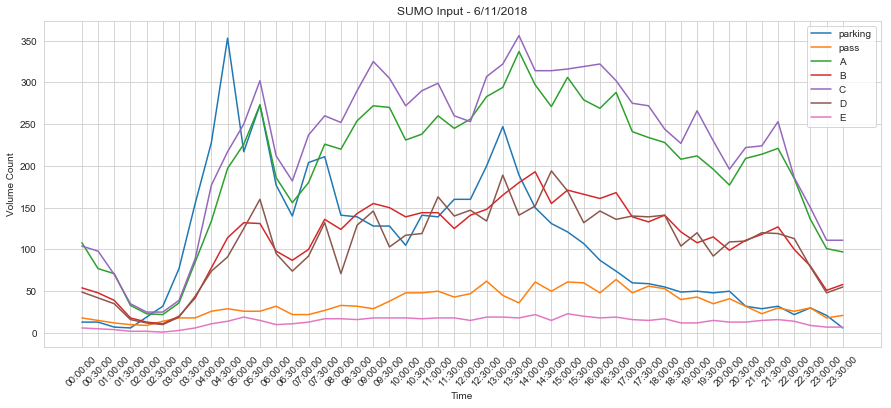

In [21]:

gf.plot_vol_by_type(day)

In [22]:
day['terminal_tot'] =  day[['A','B','C','D','E']].sum(axis=1)
day.head()

/Users/jseverin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,scheduled_fight_time,parking,pass,A,B,C,D,E,month,day,year,day_of_week,total_pass,date,terminal_tot
time,,,,,,,,,,,,,,,
00:00:00,2017-12-31 00:00:00,13.0,18.0,108,54,104,49,6,12,31,2017,6,352.0,2017-12-31,321
00:30:00,2017-12-31 00:30:00,13.0,15.0,77,48,98,42,5,12,31,2017,6,298.0,2017-12-31,270
01:00:00,2017-12-31 01:00:00,7.0,12.0,71,39,70,35,4,12,31,2017,6,238.0,2017-12-31,219
01:30:00,2017-12-31 01:30:00,6.0,10.0,33,18,35,16,2,12,31,2017,6,120.0,2017-12-31,104
02:00:00,2017-12-31 02:00:00,19.0,9.0,23,13,25,12,2,12,31,2017,6,103.0,2017-12-31,75


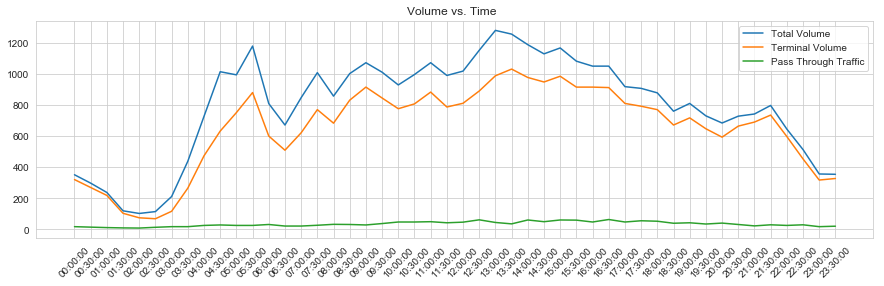

In [23]:

gf.plot_tot_vs_term(day)

## Pie Chart to show statistics about this days distribution of volume

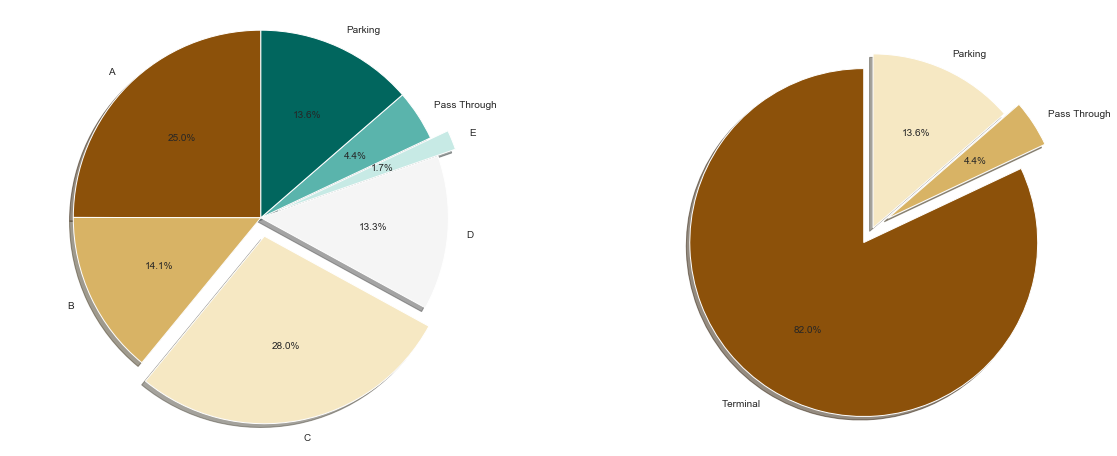

In [24]:

gf.plot_pie_all(day)

## Number of vehicles on this day:

In [25]:
day['total_pass'].sum()

38289.0

In [26]:
terminal_dict = {
    "A":['A_top_1','A_top_2','A_top_3','A_bot_1','A_bot_2','A_bot_3'],
    "B":['B_top_1','B_top_2','B_top_3','B_bot_1','B_bot_2','B_bot_3'],
    "C":['C_top_1','C_top_2','C_top_3','C_bot_1','C_bot_2','C_bot_3'],
    "D":['D_depart_1','D_depart_2','D_arrive_1','D_arrive_2','D_service'],
    "E":['E_top_1','E_top_2','E_top_3','E_bot_1','E_bot_2','E_bot_3'],
    "parking":['park_south_term_1','park_south_term_2','park_south_term_3','park_south_term_4',
              'park_south_emp_1','park_south_emp_2','park_south_emp_3','park_north_emp_1',
              'park_north_emp_2','park_north_emp_3','park_north_emp_4','park_north_emp_5',
              'park_north_emp_6'],
    "pass":"pass_through"
}
stop_dict = {
        "A":['A_top_1','A_top_2','A_top_3','A_bot_1','A_bot_2','A_bot_3'],
        "B":['B_top_1','B_top_2','B_top_3','B_bot_1','B_bot_2','B_bot_3'],
        "C":['C_top_1','C_top_2','C_top_3','C_bot_1','C_bot_2','C_bot_3'],
        "D":['D_depart_1','D_depart_2','D_arrive_1','D_arrive_2','D_service'],
        "E":['E_top_1','E_top_2','E_top_3','E_bot_1','E_bot_2','E_bot_3'],
        "others":['park_south_term_1','park_south_term_2','park_south_term_3','park_south_term_4',
              'park_south_emp_1','park_south_emp_2','park_south_emp_3','park_north_emp_1',
              'park_north_emp_2','park_north_emp_3','park_north_emp_4','park_north_emp_5',
              'park_north_emp_6']
}

# GENERATE XML DEMAND FILE FOR SUMO

In [27]:
gf.model_to_sumo(this_folder,day,date,False)

No policy was selected
Saving to xml:  trip_2017-12-31.xml


# GENERATE ADDITIONAL FILES FOR SUMO

In [29]:
gf.create_additional_file(this_folder,stop_dict,date)

Saving to xml:  additional_2017-12-31.xml


# You now have all the inputs to run SUMO for DFW